In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mounts it to YOUR drive. Nishanth and Chad, you will have to add a shortcut to dataset-resized.
# Dataset-realized is in the folder that was shared.
import os

# Path to the dataset folder
#folder_path = '/content/drive/My Drive/dataset-resized' # All images are 512 x 384
folder_path = '/content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized'  #Chad path

Mounted at /content/drive


In [ ]:
#Get the paths/labels. This one includes an excpetion incase one fails.
def prepare_data(data_dir):
    categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']
    image_paths = []
    labels = []  # Numerical labels: 0 for Trash, 1 for Plastic, etc.

    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        try:
            for file in os.listdir(category_dir):
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_paths.append(os.path.join(category_dir, file))
                    labels.append(label)
        except Exception as e:
            print(f"Failed to process category {category}: {e}")
            continue

    return image_paths, labels

In [ ]:
image_paths, labels = prepare_data(folder_path)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        # Load the image as a PIL Image
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

In [ ]:
# Define the transformation from ResNet

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Subset
labels_mapping = {'Trash': 0, 'Plastic': 1, 'Paper': 2, 'Metal': 3, 'Glass': 4, 'Cardboard': 5}
datasets_by_label = {}
data_loaders_by_label = {}

for label_name, label_id in labels_mapping.items():
    # Filter indices for the current label
    indices = [i for i, label in enumerate(labels) if label == label_id]

    # Use the indices to create a Subset
    subset = Subset(CustomDataset(image_paths, labels, transform=transform), indices)

    # Store the subset using the label_name as key
    datasets_by_label[label_name] = subset

    # Create a DataLoader for the current label's dataset
    data_loader = DataLoader(subset, batch_size=32, num_workers=1, shuffle=False)

    # Store the DataLoader using the label_name as key
    data_loaders_by_label[label_name] = data_loader

In [ ]:
# Assuming you have the original 'image_paths' and 'labels' lists available

for label_name, subset in datasets_by_label.items():
    print(f"\nExamples from class: {label_name}")

    # Get the first few indices from the subset.indices
    example_indices = subset.indices[:5]  # Adjust the number of examples as needed

    for idx in example_indices:
        print(f"Path: {image_paths[idx]}, Label ID: {labels[idx]}")



Examples from class: Trash
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Trash/trash101.jpg, Label ID: 0
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Trash/trash100.jpg, Label ID: 0
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Trash/trash102.jpg, Label ID: 0
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Trash/trash10.jpg, Label ID: 0
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Trash/trash1.jpg, Label ID: 0

Examples from class: Plastic
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Plastic/plastic106.jpg, Label ID: 1
Path: /content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized/Plastic/plastic105.jpg, Label ID: 1
Path: /content/drive/My Drive/24-782: ML 

In [ ]:

# link to source: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html
import json
import urllib.request

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

# Download the file
urllib.request.urlretrieve(url, "imagenet_class_index.json")

# Load the JSON data
with open("imagenet_class_index.json") as file:
    class_names = [v[1] for v in json.load(file).values()]

# Now class_names contains the list of ImageNet class names
print("Number of ImageNet classes:", len(class_names))
print("Class names:", class_names)


Number of ImageNet classes: 1000
Class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba'

In [ ]:
import torchvision.models as models

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
all_predicted_classes = []  # List to hold all predictions

for class_name, data_loader in data_loaders_by_label.items():
    print(f"\nProcessing class: {class_name}")
    batch_predictions = []  # List to hold predictions for the current DataLoader

    for images, _ in data_loader:  #we know the labels in each dataloader are all the same since we made one for each Class
        images = images.to(device)

        with torch.no_grad():
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_pred_indices = torch.argmax(probabilities, dim=1)
            batch_predictions.extend([class_names[idx] for idx in top_pred_indices.cpu().numpy()])

    all_predicted_classes.append(batch_predictions)  # Append the list of predictions for this class



Processing class: Trash

Processing class: Plastic

Processing class: Paper

Processing class: Metal

Processing class: Glass

Processing class: Cardboard


In [ ]:
for class_name, data_loader in data_loaders_by_label.items():
    # Get the number of items in the subset that the DataLoader is based on
    num_photos = len(data_loader.dataset)
    print(f"\nProcessing class: {class_name}")
    print(f"Number of photos: {num_photos}")


Processing class: Trash
Number of photos: 137

Processing class: Plastic
Number of photos: 482

Processing class: Paper
Number of photos: 594

Processing class: Metal
Number of photos: 410

Processing class: Glass
Number of photos: 501

Processing class: Cardboard
Number of photos: 403


In [ ]:
print(type(all_predicted_classes))

<class 'list'>


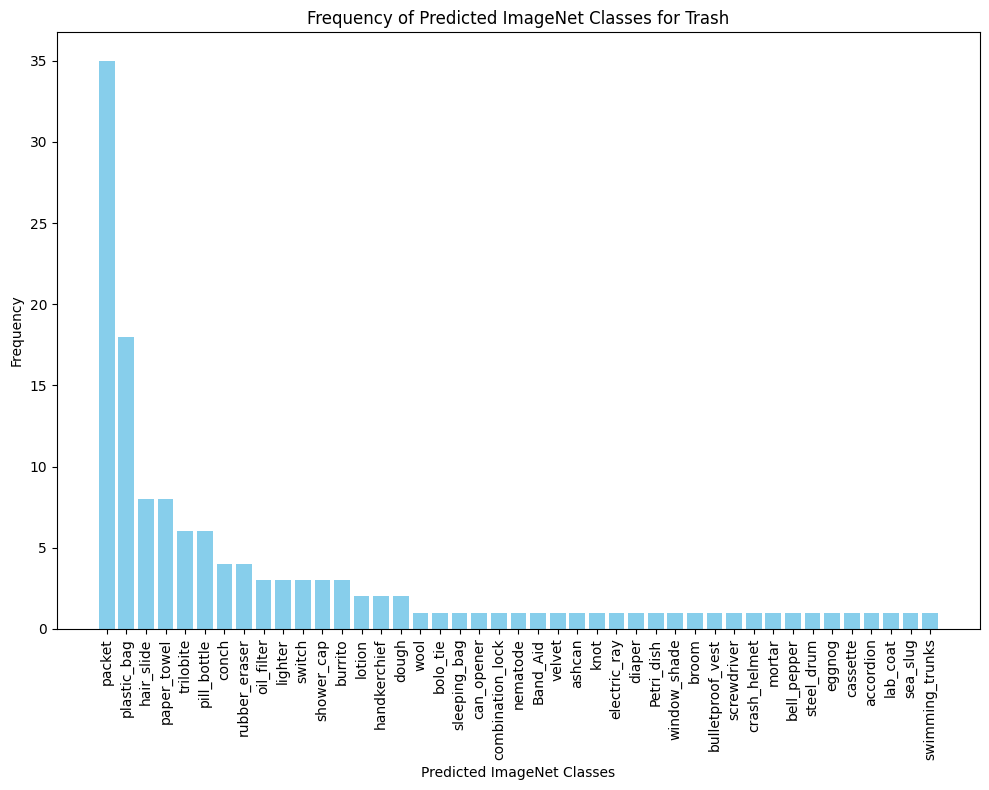

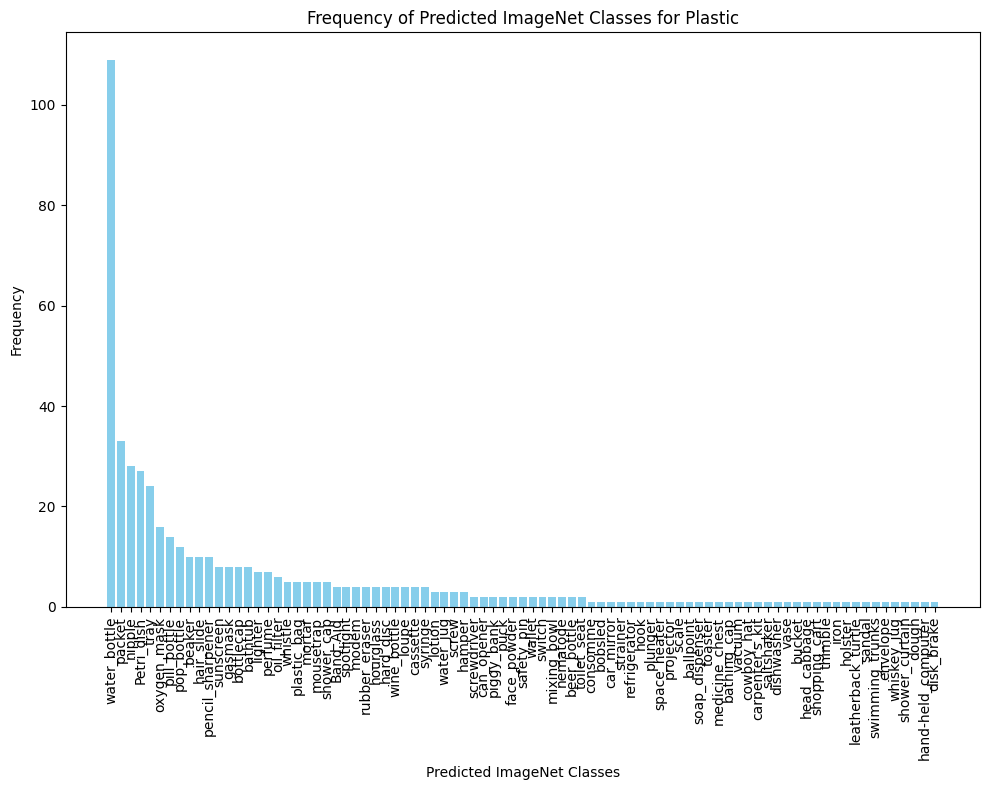

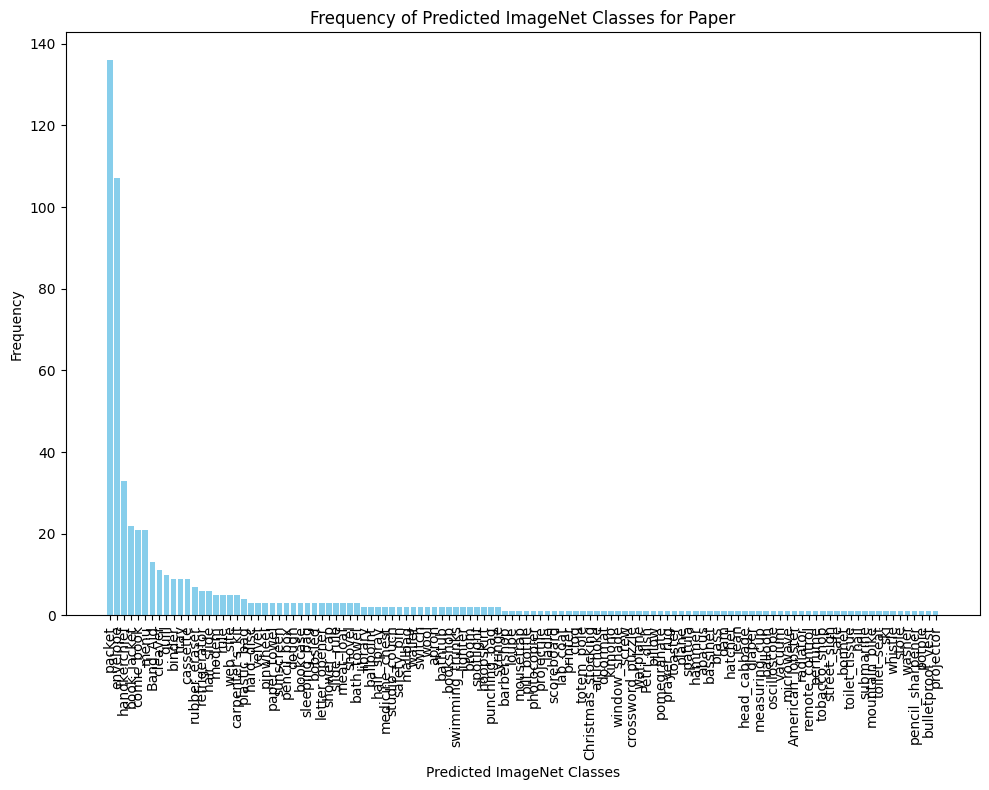

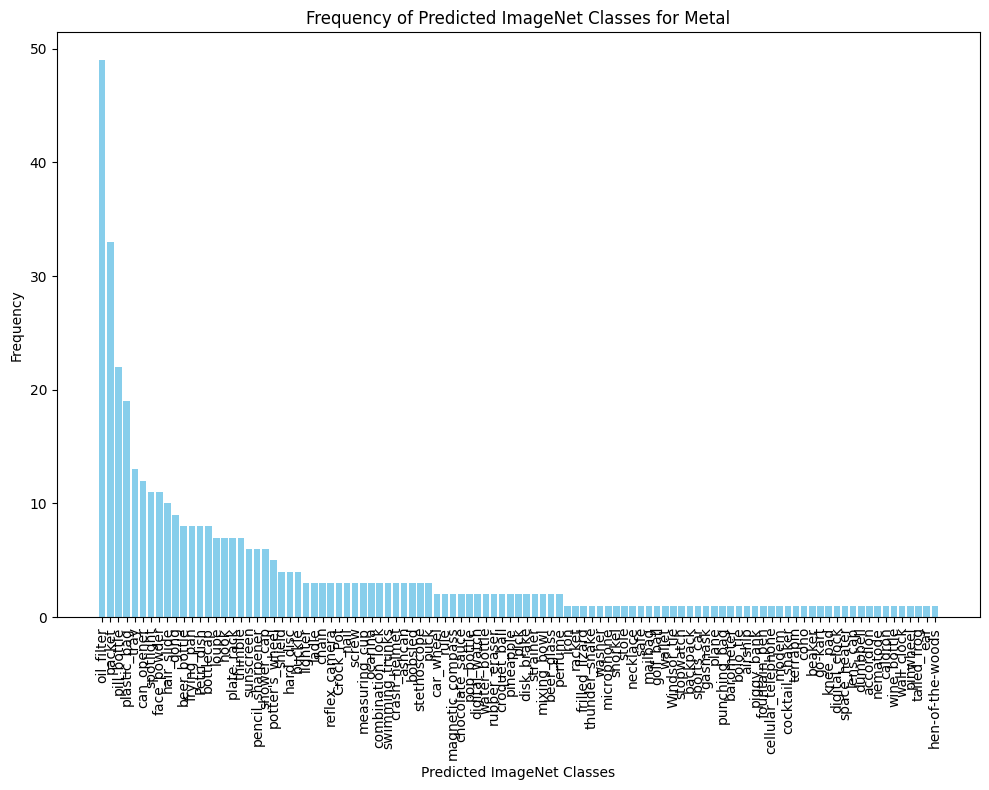

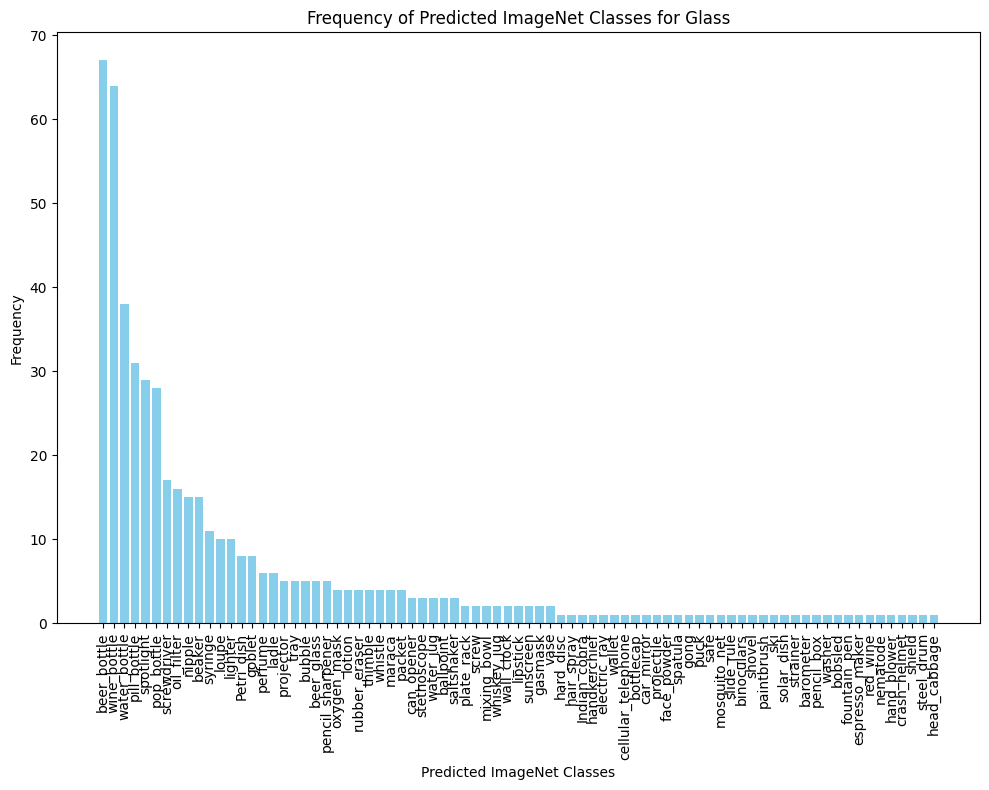

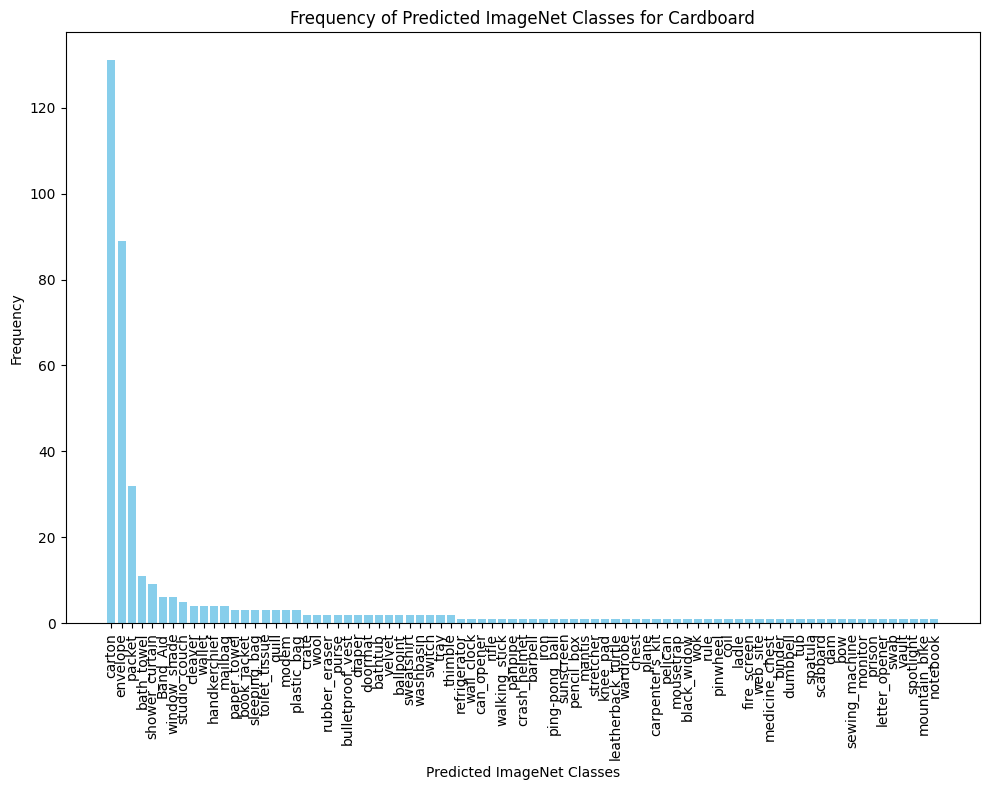

In [ ]:

categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']

for category, predicted_class_names in zip(categories, all_predicted_classes):
    # Directly use the predicted class names for counting
    prediction_counts = Counter(predicted_class_names)

    # Sort predictions by frequency
    sorted_predictions = sorted(prediction_counts.items(), key=lambda x: x[1], reverse=True)

    # Unzip into two lists for plotting
    classes, counts = zip(*sorted_predictions)

    # Create a bar chart for the current category
    plt.figure(figsize=(10, 8))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Predicted ImageNet Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate class names for better readability
    plt.title(f'Frequency of Predicted ImageNet Classes for {category}')
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


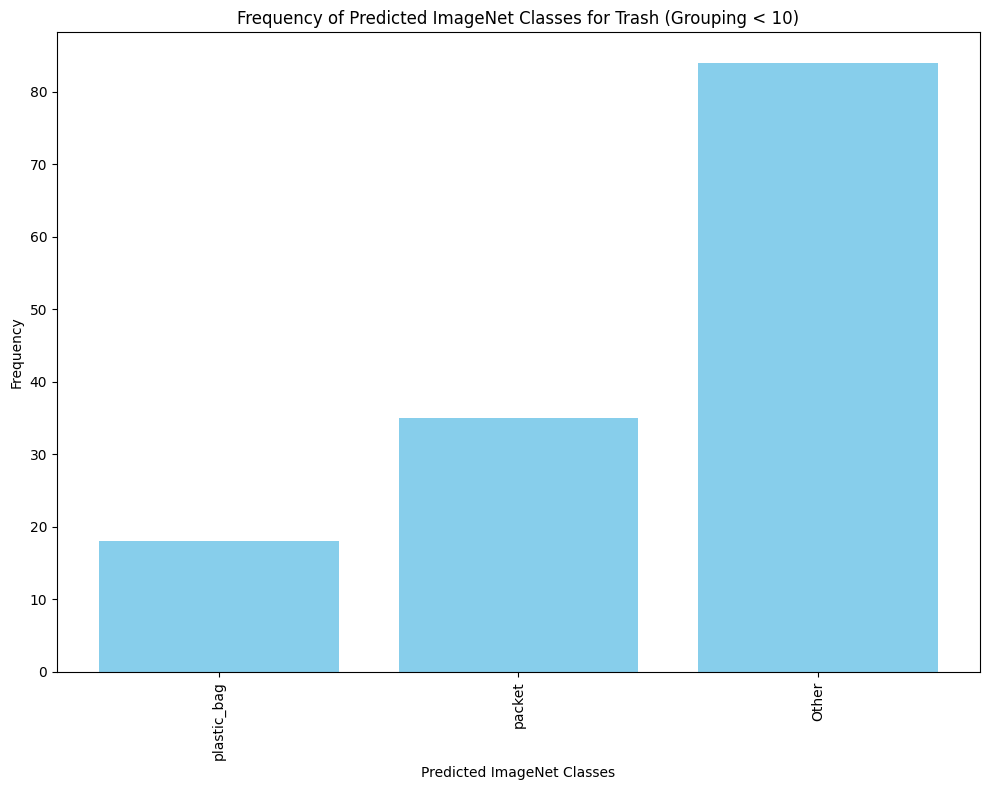

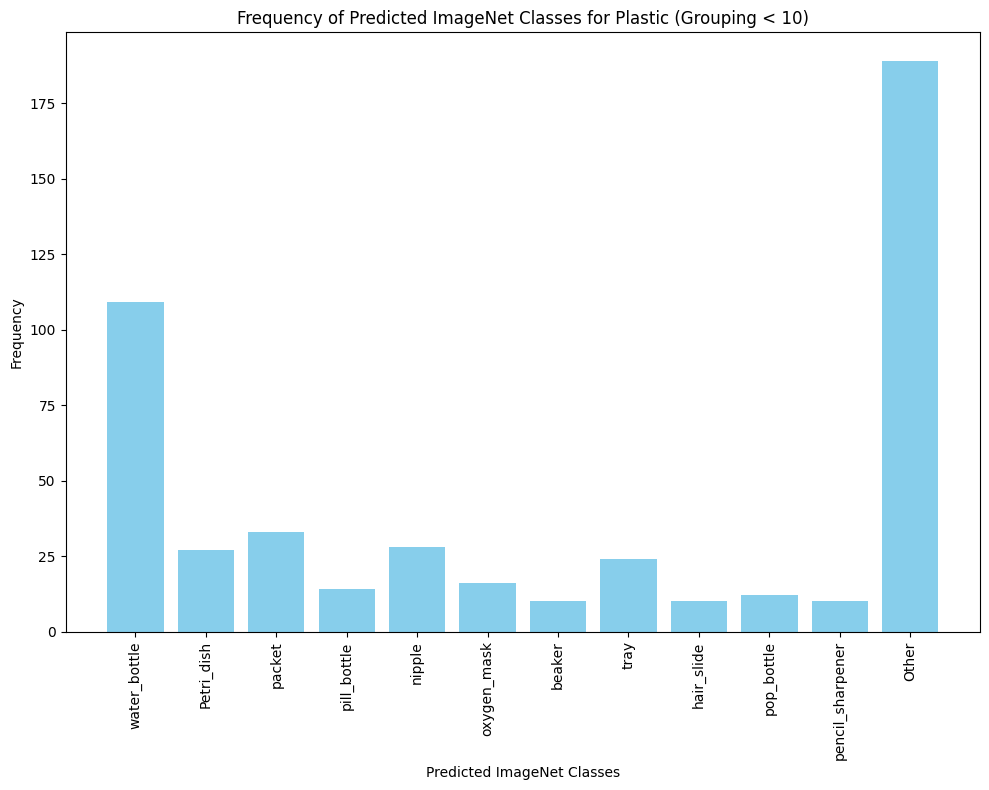

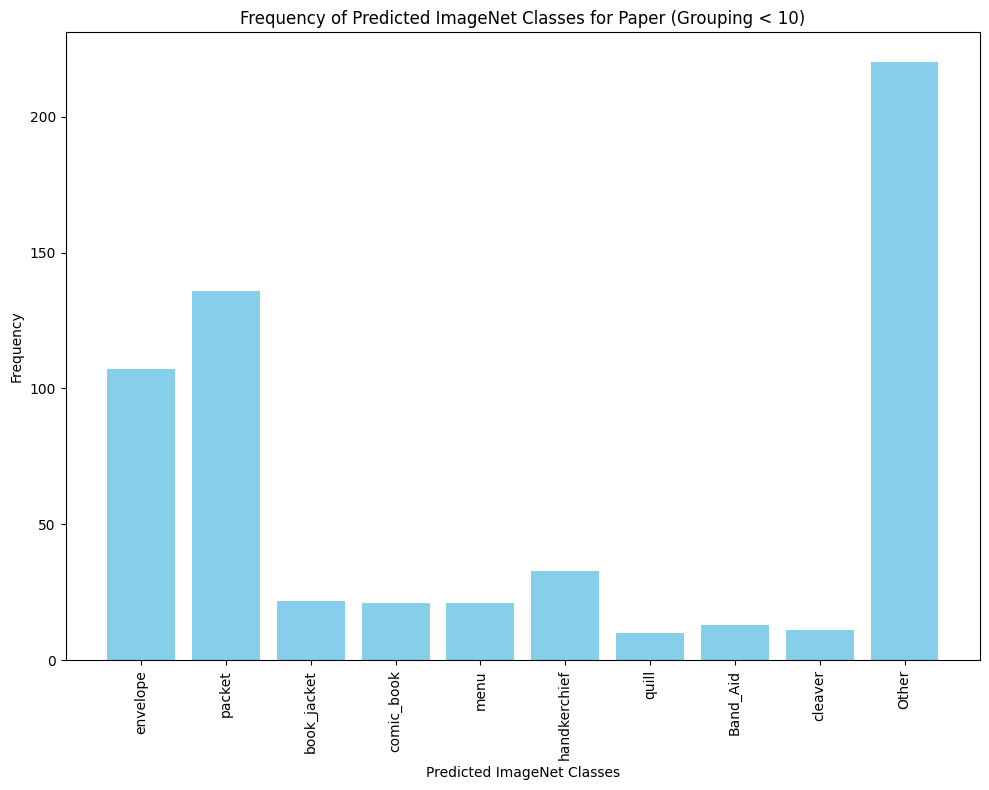

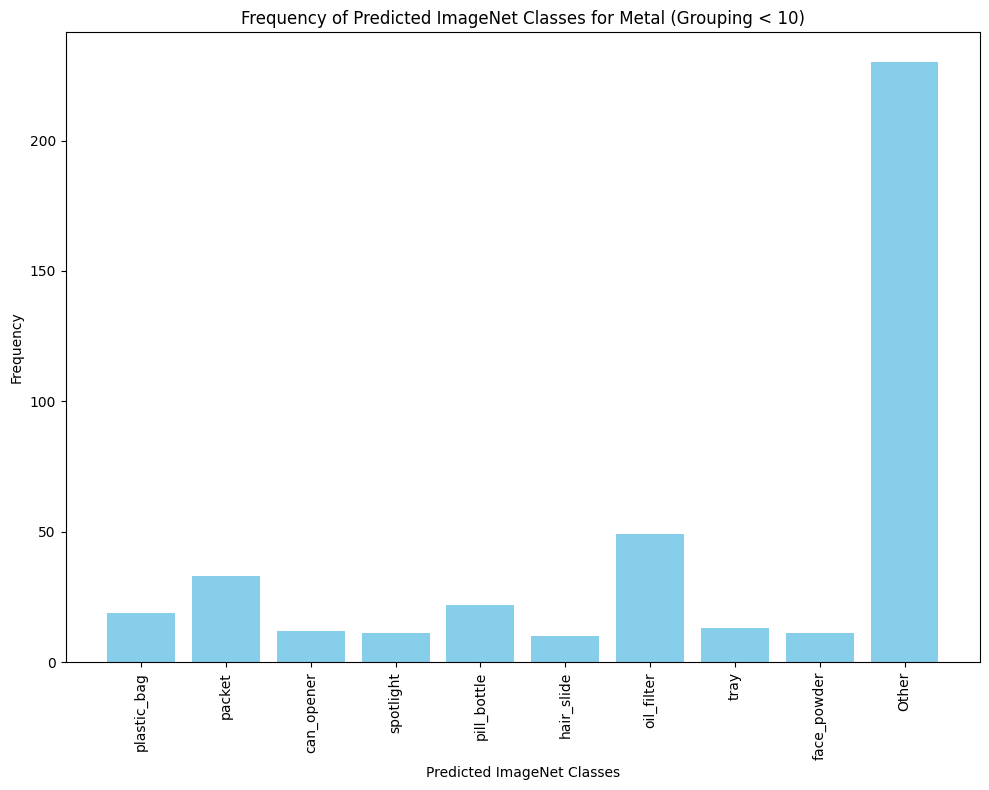

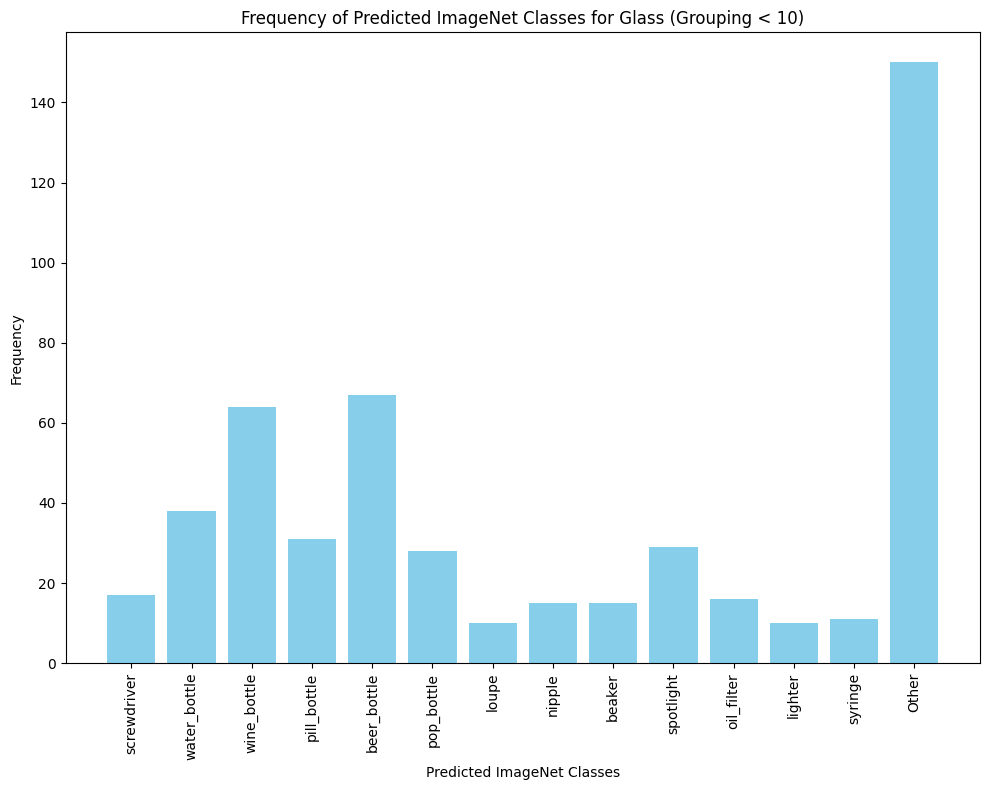

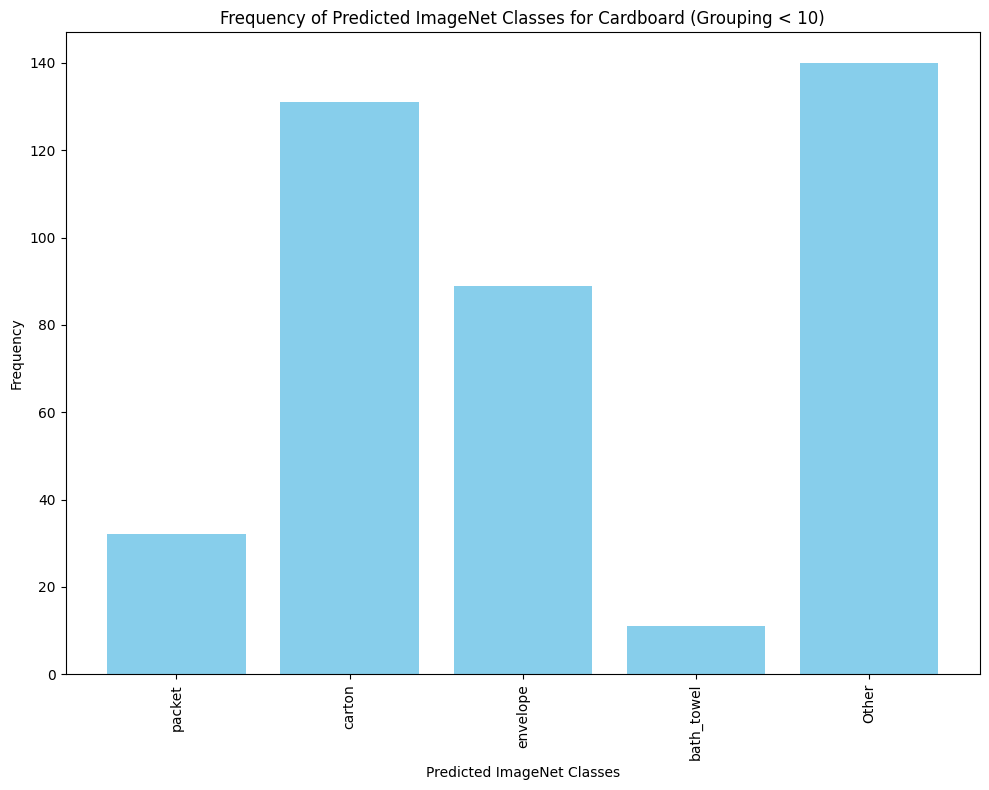

In [ ]:
for category, predicted_class_names in zip(categories, all_predicted_classes):
    prediction_counts = Counter(predicted_class_names)

    # Create a new counter to hold processed counts, including grouping infrequent classes into "Other"
    processed_counts = Counter()
    other_count = 0

    # Define the threshold below which classes are grouped into "Other"
    threshold = 10

    for class_name, count in prediction_counts.items():
        if count < threshold:
            other_count += count
        else:
            processed_counts[class_name] = count

    # Add the "Other" category count, if there are any
    if other_count > 0:
        processed_counts['Other'] = other_count

    # No need to sort again since Counter maintains insertion order and we inserted in sorted order
    classes, counts = zip(*processed_counts.items())

    # Create a bar chart for the current category
    plt.figure(figsize=(10, 8))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Predicted ImageNet Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate class names for better readability
    plt.title(f'Frequency of Predicted ImageNet Classes for {category} (Grouping < {threshold})')
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


In [ ]:


# Process counts to group infrequent classes into "Other"
processed_counts_combined = Counter()
other_count_combined = 0
threshold = 10  # Classes with counts below this threshold will be grouped into "Other"

for class_name, count in prediction_counts_combined.items():
    if count < threshold:
        other_count_combined += count
    else:
        processed_counts_combined[class_name] = count

# Add the "Other" category count, if there are any
if other_count_combined > 0:
    processed_counts_combined['Other'] = other_count_combined

# Extract classes and counts for plotting
classes_combined, counts_combined = zip(*processed_counts_combined.items())

# Create a bar chart for the combined data
plt.figure(figsize=(12, 9))
plt.bar(classes_combined, counts_combined, color='skyblue')
plt.xlabel('Predicted ImageNet Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.title(f'Combined Frequency of Predicted ImageNet Classes (Grouping < {threshold})')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


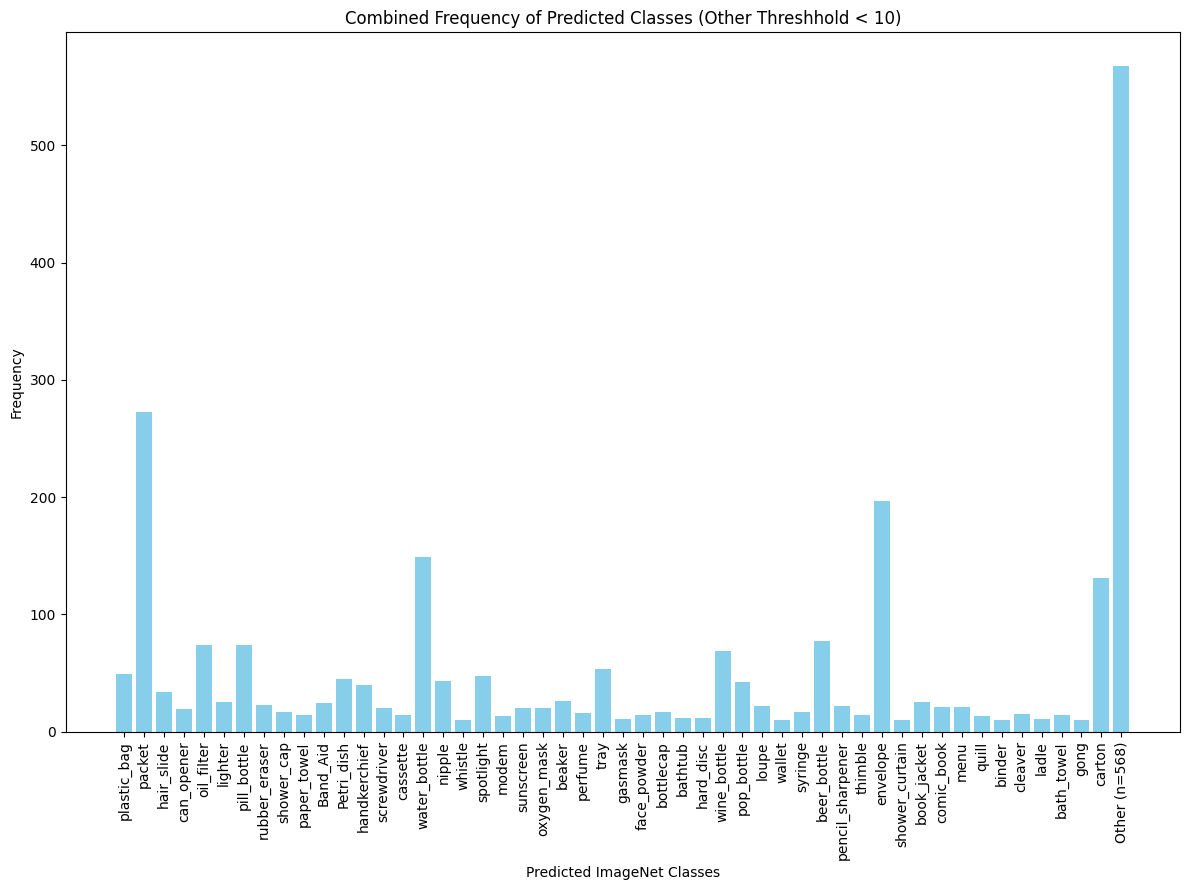

In [ ]:

# Assuming 'all_predicted_classes' is a list of lists with predicted ImageNet class names for each category
all_predictions_combined = list(chain.from_iterable(all_predicted_classes))

# Count the frequency of each predicted class across all categories
prediction_counts_combined = Counter(all_predictions_combined)

# Process counts to group infrequent classes into "Other"
processed_counts_combined = Counter()
other_count_combined = 0
threshold = 10  # Classes with counts below this threshold will be grouped into "Other"

for class_name, count in prediction_counts_combined.items():
    if count < threshold:
        other_count_combined += count
    else:
        processed_counts_combined[class_name] = count

# Add the "Other" category count, if there are any
if other_count_combined > 0:
    processed_counts_combined[f'Other (n={other_count_combined})'] = other_count_combined

# Extract classes and counts for plotting
classes_combined, counts_combined = zip(*processed_counts_combined.items())

import matplotlib.pyplot as plt

# Create a bar chart for the combined data
plt.figure(figsize=(12, 9))
plt.bar(classes_combined, counts_combined, color='skyblue')
plt.xlabel('Predicted ImageNet Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.title(f'Combined Frequency of Predicted Classes (Other Threshhold < {threshold})')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [ ]:
categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']  # Example category names

for category, predictions in zip(categories, all_predicted_classes):
    unique_predictions = set(predictions)
    num_unique_predictions = len(unique_predictions)
    print(f"Category '{category}' has {num_unique_predictions} unique predictions.")


Category 'Trash' has 43 unique predictions.
Category 'Plastic' has 85 unique predictions.
Category 'Paper' has 118 unique predictions.
Category 'Metal' has 103 unique predictions.
Category 'Glass' has 79 unique predictions.
Category 'Cardboard' has 81 unique predictions.


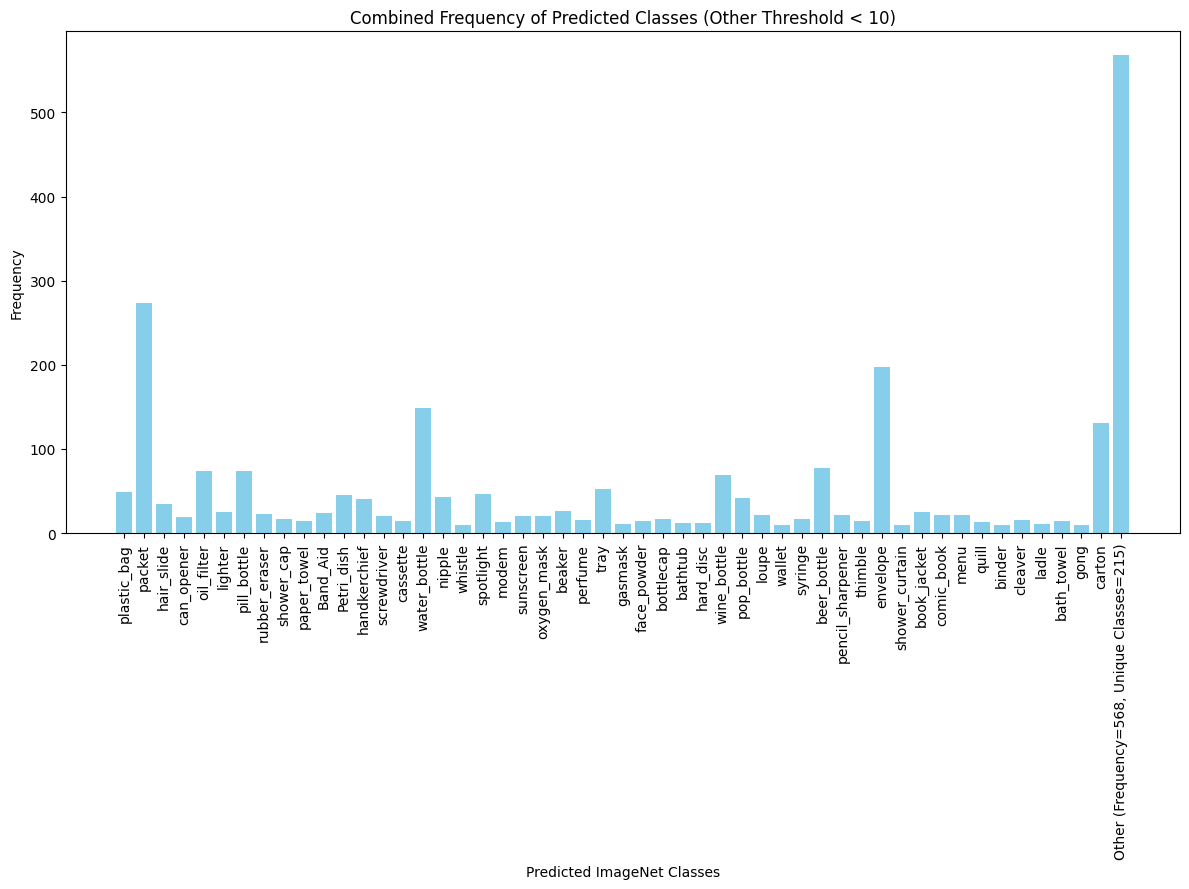

In [ ]:
# Assuming 'all_predicted_classes' is a list of lists with predicted ImageNet class names for each category
all_predictions_combined = list(chain.from_iterable(all_predicted_classes))

# Count the frequency of each predicted class across all categories
prediction_counts_combined = Counter(all_predictions_combined)

# Process counts to group infrequent classes into "Other"
processed_counts_combined = Counter()
other_count_combined = 0
unique_classes_grouped_into_other = 0  # Counter for the number of unique classes grouped into "Other"
threshold = 10  # Classes with counts below this threshold will be grouped into "Other"

for class_name, count in prediction_counts_combined.items():
    if count < threshold:
        other_count_combined += count
        unique_classes_grouped_into_other += 1  # Increment for each unique class grouped into "Other"
    else:
        processed_counts_combined[class_name] = count

# Add the "Other" category count, if there are any
if other_count_combined > 0:
    # Update the label to include both the total count and the number of unique classes
    processed_counts_combined[f'Other (Frequency={other_count_combined}, Unique Classes={unique_classes_grouped_into_other})'] = other_count_combined

# Extract classes and counts for plotting
classes_combined, counts_combined = zip(*processed_counts_combined.items())

# Create a bar chart for the combined data
plt.figure(figsize=(12, 9))
plt.bar(classes_combined, counts_combined, color='skyblue')
plt.xlabel('Predicted ImageNet Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.title(f'Combined Frequency of Predicted Classes (Other Threshold < {threshold})')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


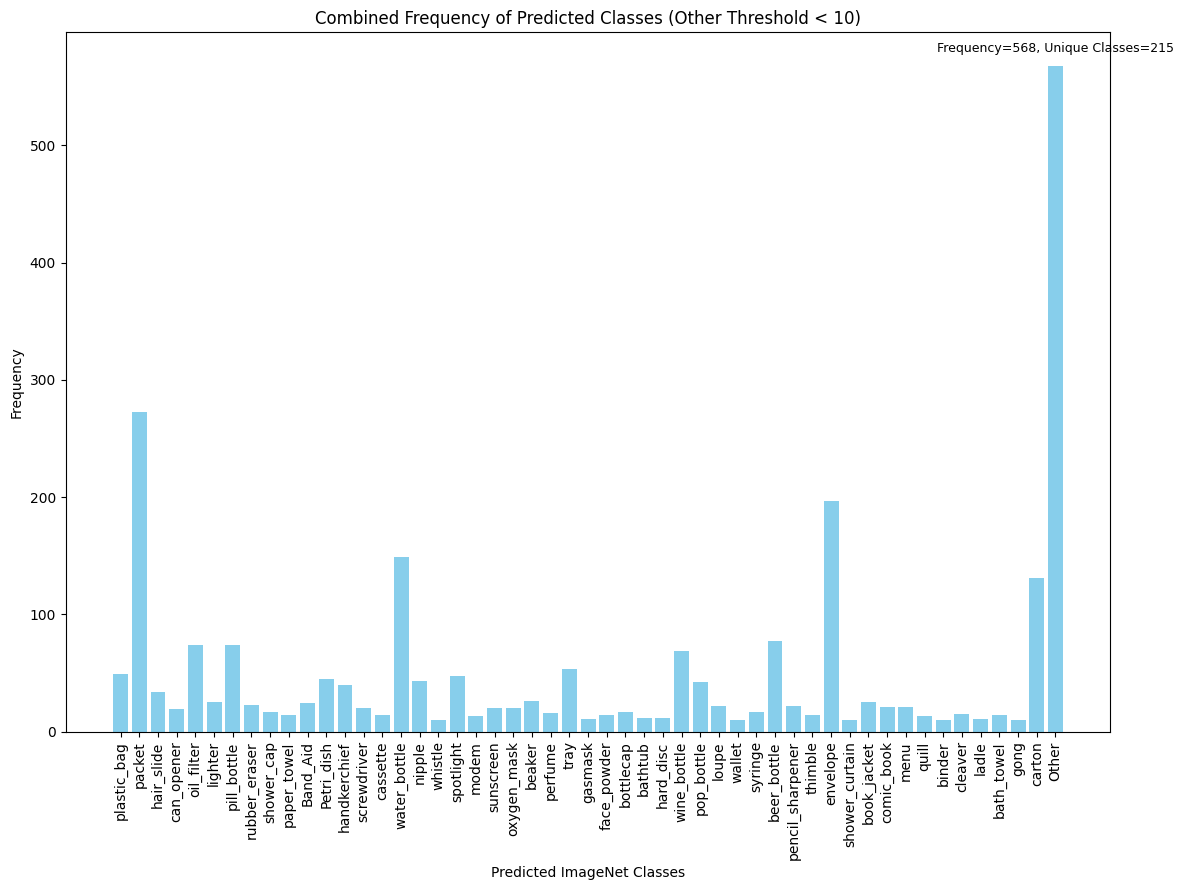

In [ ]:

all_predictions_combined = list(chain.from_iterable(all_predicted_classes))

# Count the frequency of each predicted class across all categories
prediction_counts_combined = Counter(all_predictions_combined)

# Process counts to group infrequent classes into "Other"
processed_counts_combined = Counter()
other_count_combined = 0
unique_classes_grouped_into_other = 0  # Counter for the number of unique classes grouped into "Other"
threshold = 10  # Classes with counts below this threshold will be grouped into "Other"

for class_name, count in prediction_counts_combined.items():
    if count < threshold:
        other_count_combined += count
        unique_classes_grouped_into_other += 1  # Increment for each unique class grouped into "Other"
    else:
        processed_counts_combined[class_name] = count

# Add the "Other" category count, if there are any
if other_count_combined > 0:
    processed_counts_combined['Other'] = other_count_combined

# Extract classes and counts for plotting
classes_combined, counts_combined = zip(*processed_counts_combined.items())

# Create a bar chart for the combined data
plt.figure(figsize=(12, 9))
bars = plt.bar(classes_combined, counts_combined, color='skyblue')
plt.xlabel('Predicted ImageNet Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.title(f'Combined Frequency of Predicted Classes (Other Threshold < {threshold})')

# Check if 'Other' is present to avoid errors in case there's no 'Other' category
if 'Other' in processed_counts_combined:
    # Find the position of the "Other" bar to place the annotation correctly
    other_index = classes_combined.index('Other')
    other_bar = bars[other_index]  # The bar object for "Other"

    # Annotate the "Other" bar with the detailed count
    annotation_text = f'Frequency={other_count_combined}, Unique Classes={unique_classes_grouped_into_other}'
    plt.annotate(annotation_text,
                 (other_bar.get_x() + other_bar.get_width() / 2, other_bar.get_height()),
                 textcoords="offset points",  # Interpret the xytext as offset in points
                 xytext=(0,10),  # 10 points vertical offset
                 ha='center',  # Horizontal alignment is center
                 fontsize=9)  # You can adjust the fontsize as needed

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()



